<a href="https://colab.research.google.com/github/omarelfounti/Wind-Flow-Analysis-using-Real-Meteorological-Data/blob/main/WindFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyowm smopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.2 MB/s eta 0:00:00


In [ ]:
import pyowm

def getWind(lon,lat): 
    owm = pyowm.OWM('db2d73c1d173f2cd1cd3f16e14d78789') 
    mgr = owm.weather_manager()
    observation = mgr.weather_at_coords(lat,lon)
    weather = observation.weather
    return weather.wind()

In [ ]:
import numpy as np
import math
import json
import datetime
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def loadVelocityMask(u,v,mask):
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x] == 255:
                u[y, x] = 0.0
                v[y, x] = 0.0
    return True

def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        p[:, -1] = p[:, -2] 
        p[0, :]  = p[1, :]  
        p[:, 0]  = p[:, 1]  
        p[-1, :] = p[-2, :]
    return p

def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        
        u[0, :] = 1
        u[:, 0] = 1
        u[:, -1] = 1
        u[-1, :] = 1
        
        v[0, :] = 0
        v[-1, :] = 0
        v[:, 0] = 0
        v[:, -1] = 0
    return u, v, p

def cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, mask, deg, speed):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    for n in range(nt):
        loadVelocityMask(u,v,mask)
        un = u.copy()
        vn = v.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        loadVelocityMask(u,v,mask)

        wind_u = -math.sin(deg/180.0*math.pi)*speed
        wind_v = -math.cos(deg/180.0*math.pi)*speed
       
        u[0, :] = wind_u
        u[:, 0] = wind_u
        u[:, -1] = wind_u
        u[-1, :] = wind_u
        
        v[0, :] = wind_v
        v[-1, :]= wind_v
        v[:, 0] = wind_v
        v[:, -1] = wind_v
    return u, v, p

def doSimulation(nx, ny, wind, mask, isWithUVMap):
    c = 1
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)
    X, Y = np.meshgrid(x, y)
    rho = 1
    nu = .1
    dt = .00001
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    b = np.zeros((ny, nx))
    nt = 55
    try:
        u, v, p = cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, 
                           mask, wind['deg'], wind['speed'])
    except:
        u, v, p = cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, 
                           mask, 0, wind['speed'])
        
    velocity = np.zeros((ny, nx))
    velocity[1:-1,1:-1] = np.sqrt(pow(v[1:-1,1:-1],2)+pow(u[1:-1,1:-1],2))
    
    umax = np.amax(u)
    umin = np.amin(u)
    vmax = np.amax(v)
    vmin = np.amin(v)
    uvImage = np.zeros((ny, nx, 4), np.uint8)
    for y in range(ny):
        for x in range(nx):
            uvImage[x,y] = (
                0,
                math.floor(255 * (v[x,y] - vmin) / (vmax - vmin)),
                math.floor(255 * (u[x,y] - umin) / (umax - umin)),
                255)
    uvmeta = {'source': 'http://www.hirax.net', 
        'date': str(datetime.datetime.now()),
        'width': nx,
        'height': ny,
        'uMin': umin,
        'uMax': umax,
        'vMin': vmin,
        'vMax': vmax
       }
    if('withUVMap'==isWithUVMap):
        return u, v, velocity, uvmeta, uvImage
    if('withOutUVMap'==isWithUVMap):
        return u, v, velocity
    else:
        return u, v, velocity

In [ ]:
lon=36.71661; lat=-4.411576 #Hometown
wind = getWind(lon, lat)
if 'deg' in wind.keys():print(wind['deg']) 
print(wind['speed']);

114
4


In [ ]:
import smopy
import cv2
import numpy as np
import matplotlib.pyplot as plt

def getMapFromOSM(lon,lat, nx, ny):
    angle=0.000001
    map = smopy.Map((lon,lat,lon+angle,lat+angle),z=19)
    mapImg = map.to_numpy()
    return mapImg, cv2.resize(mapImg, (nx, ny))

def getMaskFromMap(mapImg):
    lower = np.array([100,19,100])
    upper = np.array([150,20,250])
    hsv = cv2.cvtColor(mapImg, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)   
    maskedMapImg = cv2.bitwise_and(mapImg, mapImg, mask)
    return maskedMapImg, mask

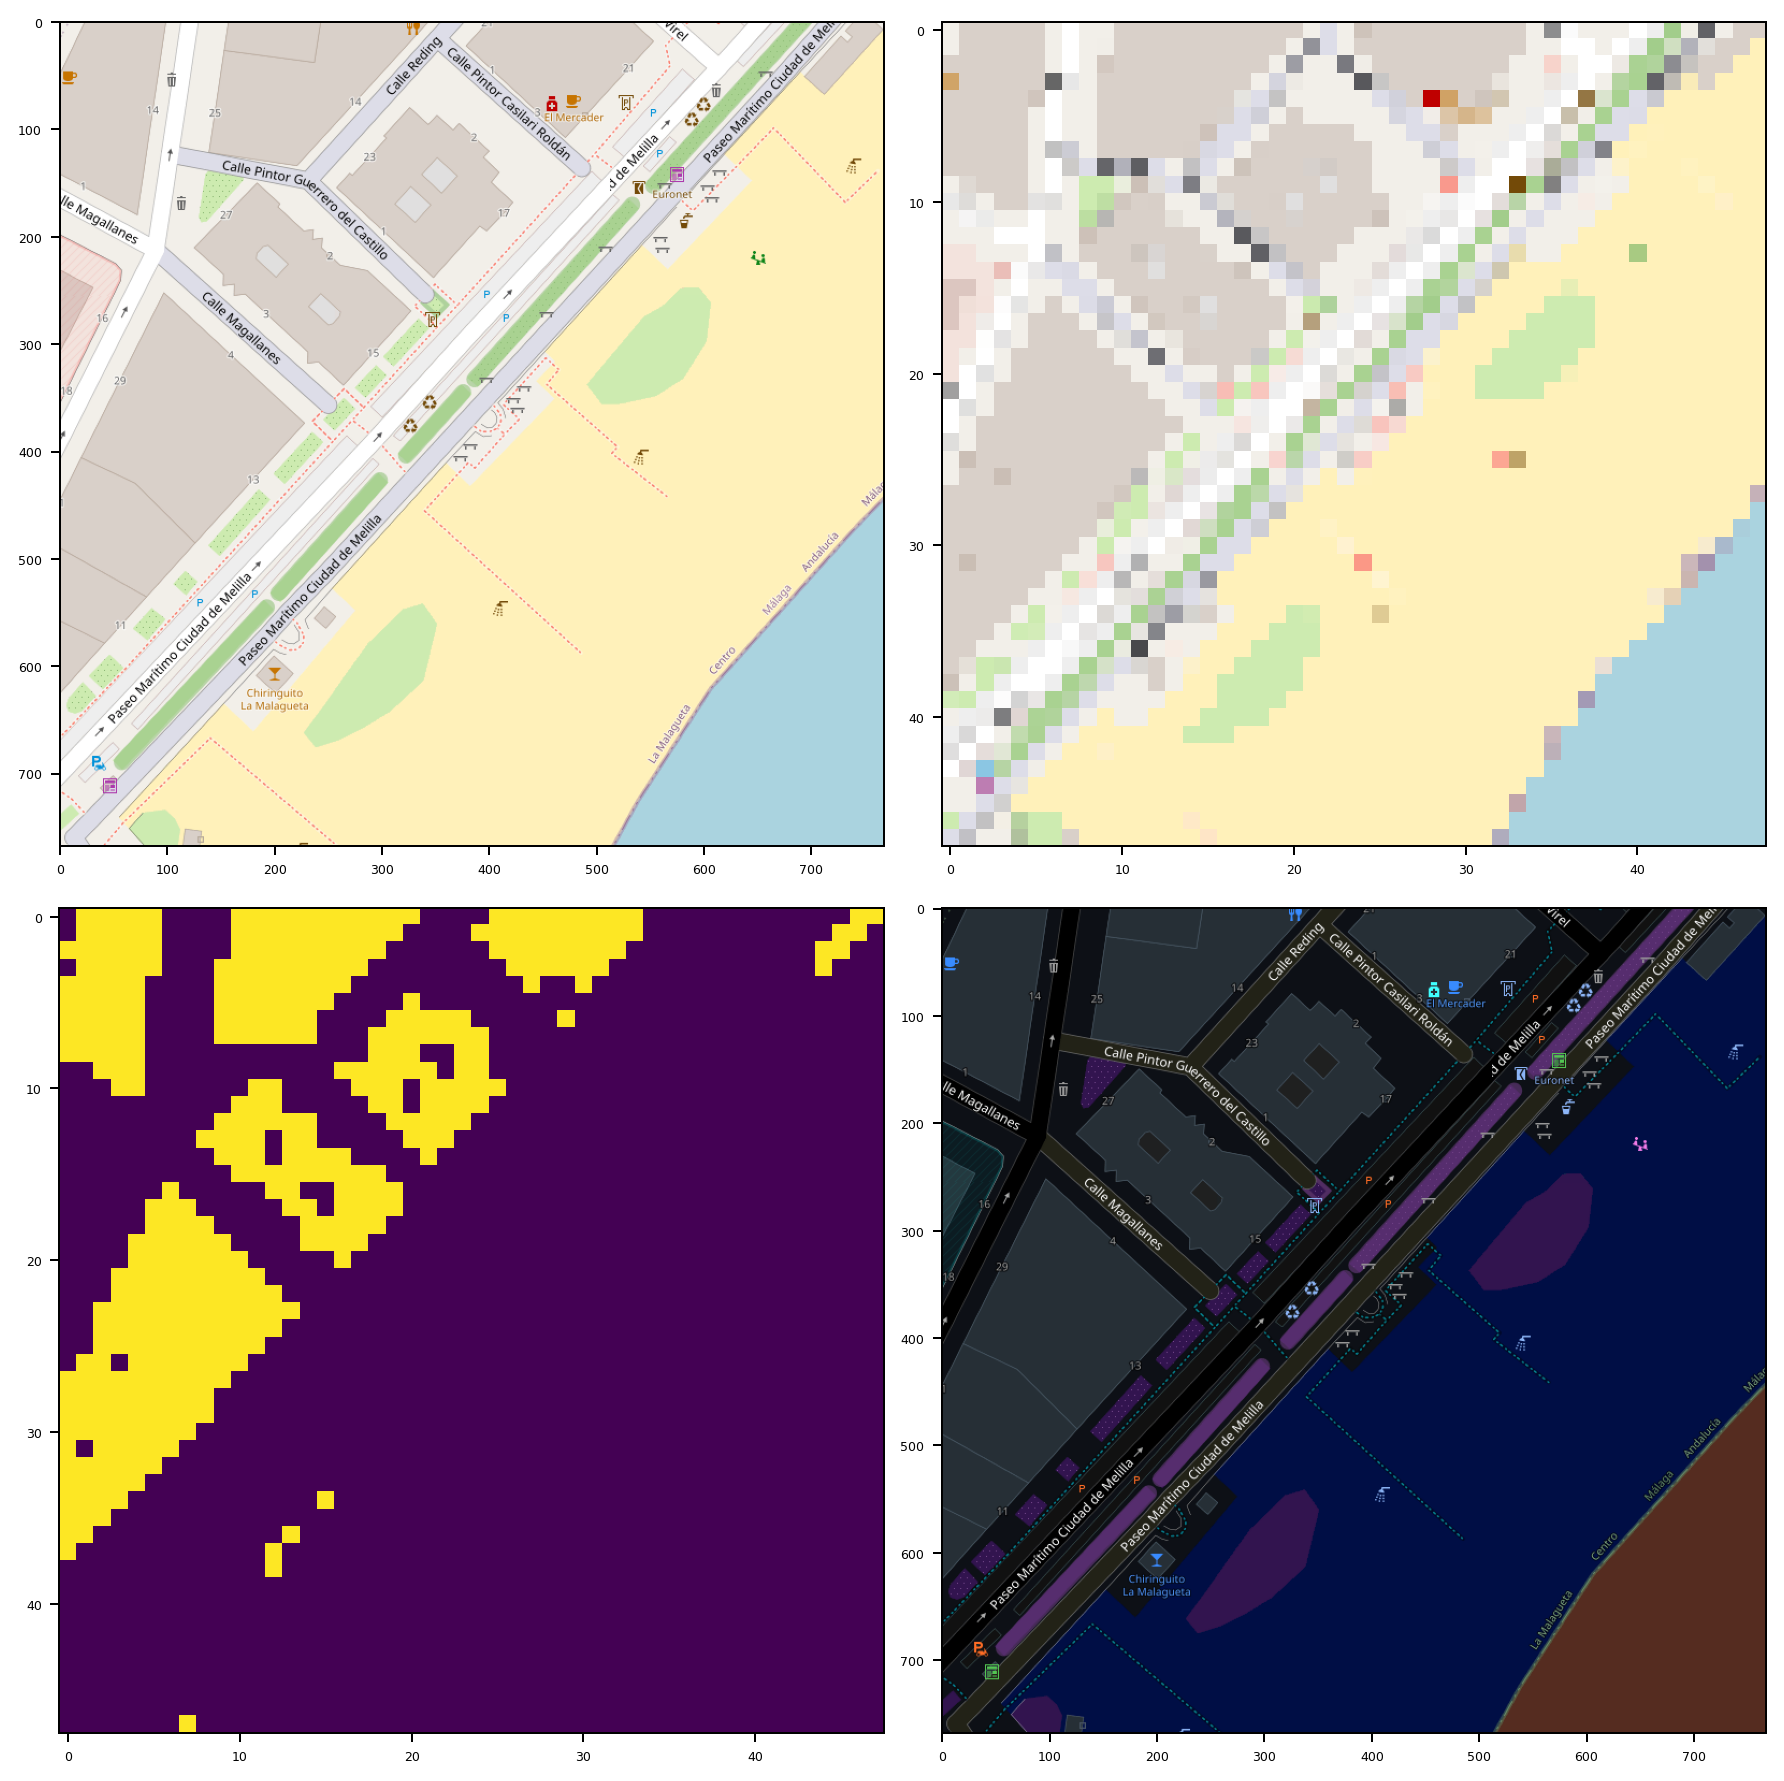

"\ncv2.imwrite('mapimg.png',mapImg)\ncv2.imwrite('lowImg.png',lowImg)\ncv2.imwrite('lowMask.png',lowMask)\ncv2.imwrite('negaMap.png',negaMap)\n"

In [ ]:
fig = plt.figure(figsize=(10,10), dpi=180)


ratio = 16  
nx = int(768/ratio); ny = int(768/ratio)
myLon = lon; myLat = lat
mapImg, lowImg = getMapFromOSM(myLon, myLat, nx, ny)    
lowImg, lowMask = getMaskFromMap(lowImg)                
negaMap = 255 - mapImg                                  

ax1 = fig.add_subplot(221)
ax1.tick_params(labelsize=5)
ax1.imshow(mapImg)

ax2 = fig.add_subplot(222)
ax2.tick_params(labelsize=5)
ax2.imshow(lowImg)

ax3 = fig.add_subplot(223)
ax3.tick_params(labelsize=5)
ax3.imshow(lowMask)

ax4 = fig.add_subplot(224)
ax4.tick_params(labelsize=5)
ax4.imshow(negaMap)
fig.tight_layout()
plt.show()



'''
cv2.imwrite('mapimg.png',mapImg)
cv2.imwrite('lowImg.png',lowImg)
cv2.imwrite('lowMask.png',lowMask)
cv2.imwrite('negaMap.png',negaMap)
'''

In [ ]:
nit = 100
u, v, velocity = doSimulation(nx, ny, wind, lowMask, 'withOutUVMap')

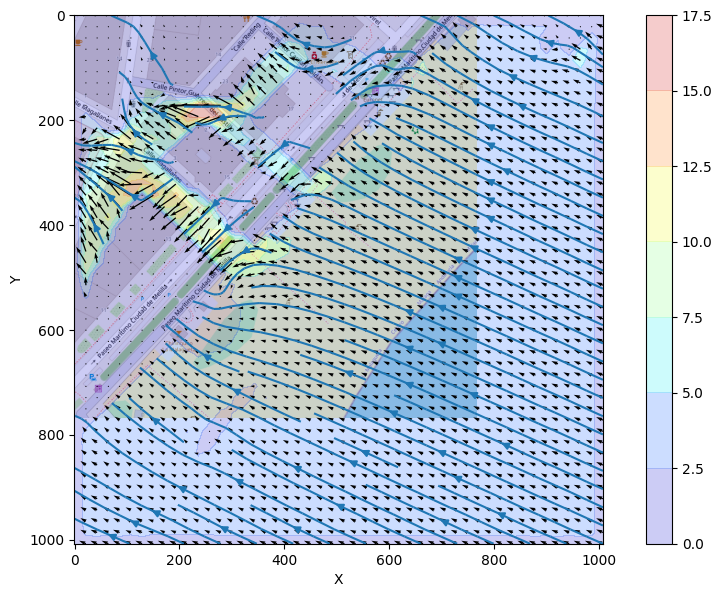

In [ ]:
fig = plt.figure(figsize=(11, 7), dpi=100)

plt.imshow(mapImg)

ratio=21
plotX, plotY = np.meshgrid(np.linspace(0, nx*ratio, nx),
               np.linspace(0, ny*ratio, ny))
plt.contourf(plotX, plotY, velocity, alpha=0.2, cmap=cm.jet) 
plt.colorbar()
plt.quiver(plotX, plotY, u, v)
plt.streamplot(plotX, plotY, u, -v)
plt.xlabel('X'); plt.ylabel('Y')

plt.savefig('figure1.png')

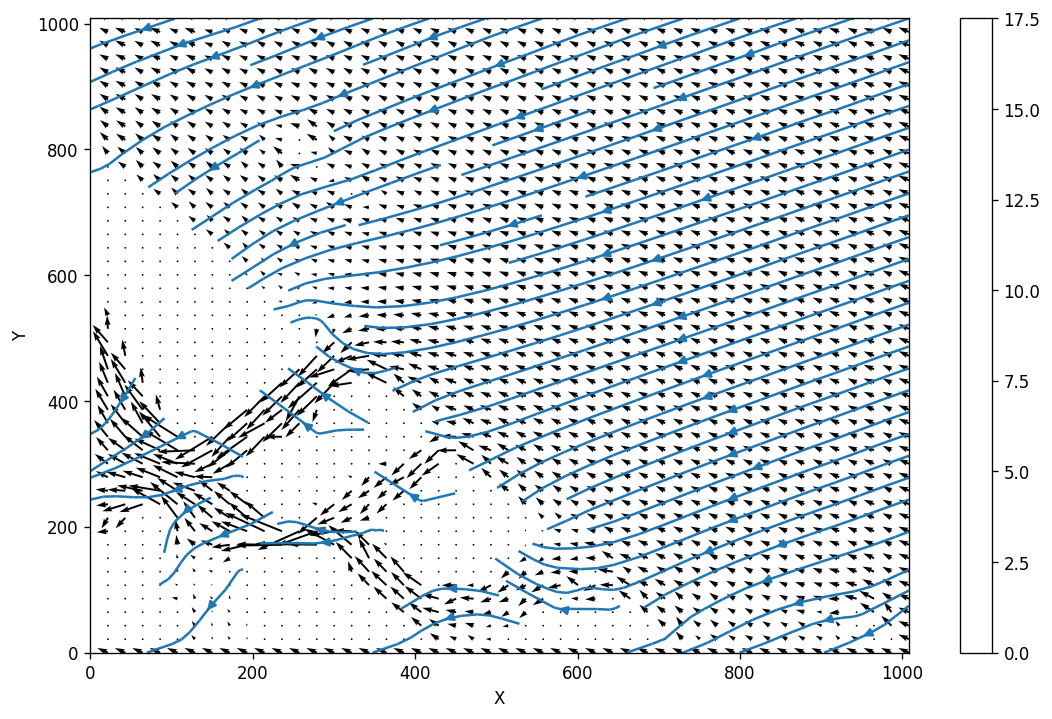

In [ ]:
fig = plt.figure(figsize=(11, 7), dpi=120)
plotX, plotY = np.meshgrid(np.linspace(0, nx*ratio, nx),
               np.linspace(0, ny*ratio, ny))
plt.contourf(plotX, plotY, velocity, alpha=0.0, cmap=cm.jet)   
plt.colorbar()
plt.quiver(plotX, plotY, u, v)                                 
plt.streamplot(plotX, plotY, u, -v)
plt.xlabel('X'); plt.ylabel('Y')

plt.savefig('figure2.png')

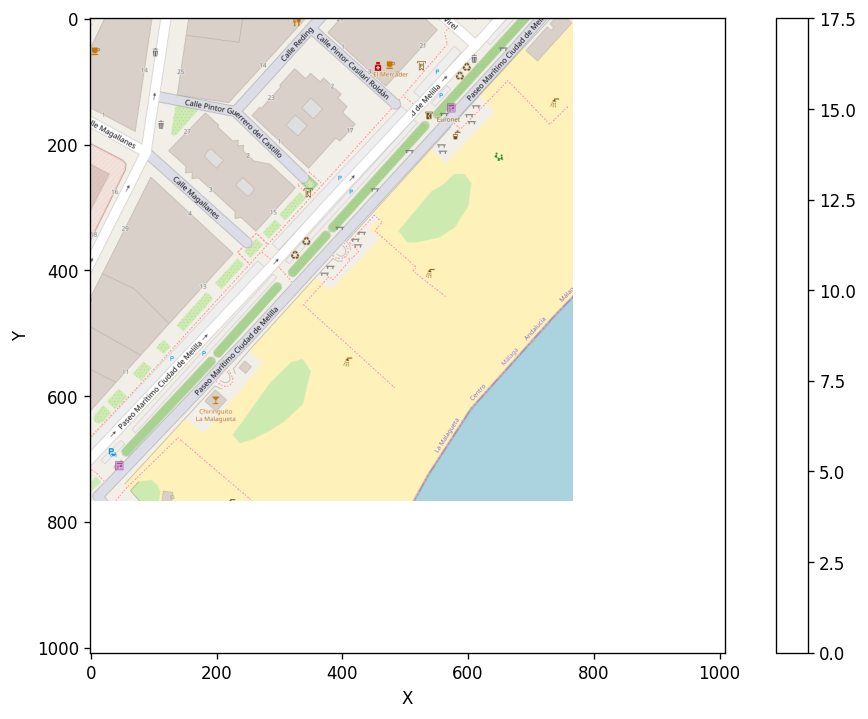

In [ ]:
fig = plt.figure(figsize=(11, 7), dpi=120)

plt.imshow(mapImg)
plotX, plotY = np.meshgrid(np.linspace(0, nx*ratio, nx),
               np.linspace(0, ny*ratio, ny))
plt.contourf(plotX, plotY, velocity, alpha=0.0, cmap=cm.jet)   
plt.colorbar()
plt.xlabel('X'); plt.ylabel('Y')

plt.savefig('figure3.png')

NameError: ignored

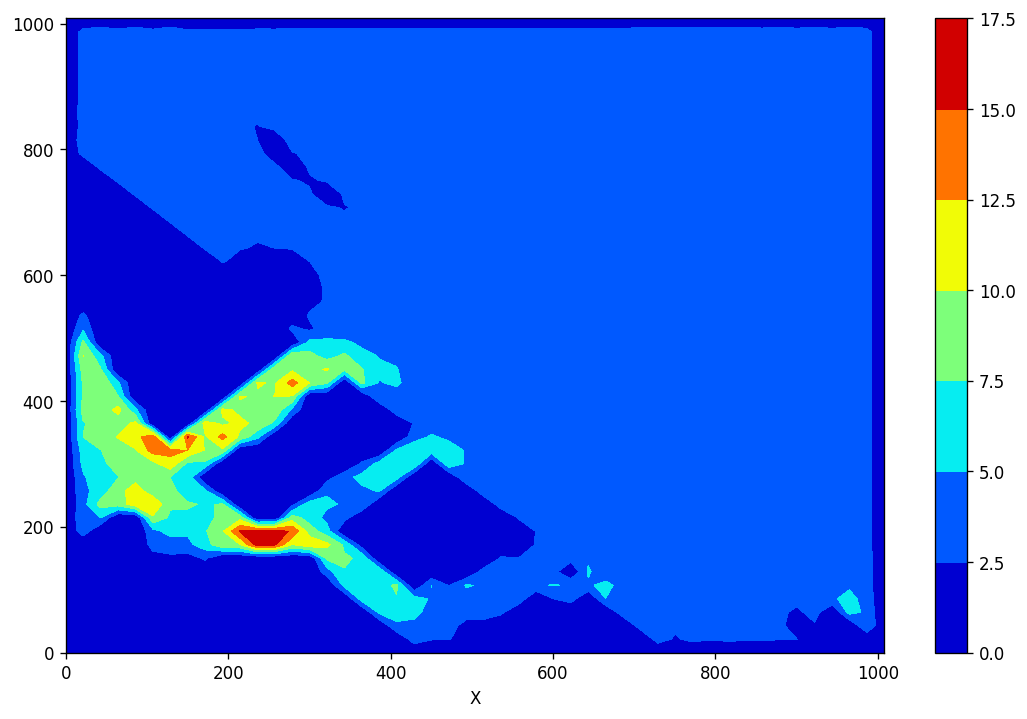

In [ ]:
fig = plt.figure(figsize=(11, 7), dpi=120)

plotX, plotY = np.meshgrid(np.linspace(0, nx*ratio, nx),
                              np.linspace(0, ny*ratio, ny))
plt.contourf(plotX, plotY, velocity, alpha=1.0, cmap=cm.jet)   
plt.colorbar()
plt.xlabel('X'); pyplot.ylabel('Y')

plt.savefig('figure4.png')

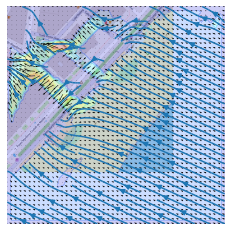

In [ ]:
fig = plt.imshow(mapImg)

plotX, plotY = np.meshgrid(np.linspace(0, nx*ratio, nx),
                              np.linspace(0, ny*ratio, ny))
plt.contourf(plotX, plotY, velocity, alpha=0.2, cmap=cm.jet)
plt.quiver(plotX, plotY, u, v) 
plt.streamplot(plotX, plotY, u, -v)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)